In [0]:
# a few packages we need to import

# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import itertools

# Exercise 1 - REINFORCE

The goal of this exercise is to implement the simplest policy gradient algorith, REINFORCE, and then augment it with a baseline coming from an approximation of the value function. We will use this algorithm on the inverted pendulum model. The class below defines the pendulum model and some helper function to simulate it.

In [0]:
class Pendulum:
    """
    This class describes an inverted pendulum and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class
        """
        #gravity constant
        self.g=9.81
        
        # number of dimensions (angle and angular velocity)
        self.num_states = 2
        
        # the available control inputs
        self.controls = np.array([-5., 0., 5.])
        self.nb_controls = len(self.controls)

        # the maximum velocity
        self.vmax = 6.
        # the range of allowable states
        self.state_range = np.array([[0, 2*np.pi],[-self.vmax, self.vmax]])

        #simulation step
        self.delta_t = 0.1
        # internal integration step
        self._internaldt = 0.01
        self._integration_ratio = int(round(self.delta_t / self._internaldt))
        
            
    def step(self,x,u):
        """
        This function integrates the pendulum for one step of self.delta_t seconds
        
        Inputs:
        x: state of the pendulum (x,v) as a 2D numpy array
        u: control as a scalar
        
        Output:
        the state of the pendulum as a 2D numpy array at the end of the integration
        """
        x_next = x[0]
        v_next = x[1]
        for i in range(self._integration_ratio):
            x_next = (x_next + self._internaldt * v_next)%(2*np.pi)
            v_next = np.clip(v_next + self._internaldt * (u-self.g*np.sin(x_next)), -self.vmax, self.vmax)
        return np.array([x_next,v_next])
    
    def simulate(self, x0, policy, T):
        """
        This function simulates the pendulum for T seconds from initial state x0 using a policy
        (policy is called as policy(x) and returns one control)
        
        Inputs:
        x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
        T: the time to integrate for
        
        Output:
        x (2D array) and u (1D array) containing the time evolution of states and control
        """
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            u[i] = policy(x[:,i])
            x[:,i+1] = self.step(x[:,i], u[i])
        return x, u

In [0]:
def animate_pendulum(x, dt):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation - dt is the sampling time (0.1s normally)
    """
    
    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    plotx = x[:,::steps]
    
    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)
    
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])
        
        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

This function can be used to plot the results of a simulation of the pendulum

In [0]:
def plot_results(pend, val, pol, policy, animate=True):
    """
    This function plots the results. It displays the value function, the policy for all states.
    Then it integrates the pendulum from state [0,0] and displays the states and control as a function of time
    Finally it shows an animation of the result
    """
    x0 = np.array([0.,0.])

    x, u = pend.simulate(x0, policy, 10)

    plt.figure(figsize=[6,6])
    plt.imshow(val, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    plt.figure(figsize=[6,6])
    plt.imshow(pol, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')

    time = np.linspace(0.,20., len(x[0,:]))
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time,x[0,:])
    plt.ylabel('angle')
    plt.subplot(3,1,2)
    plt.plot(time,x[1,:])
    plt.ylabel('velocity')
    plt.subplot(3,1,3)
    plt.plot(time[:-1],u)
    plt.ylabel('control')
    if animate:
        animate_pendulum(x, pend.delta_t)

## Reinforcement learning problem

We would like to get the pendulum upright starting from the down rest position. It has two states, its angle $\theta$ (where $\theta=0$ means that the pendulum is down) and its angular velocity $\omega$. The state of the system is $x = [\theta^T \omega^T]^T$. We also assume that we have only 3 possible control inputs $[-5, 0, 5]$.

We formulate this problem as a finite horizon problem where we want to minimize the cost
$$\min \sum_{i=0}^{N} \alpha^i g(\theta_i, \omega_i, u_i)$$
where the instantaneous cost is $$g(x,v,u) = (x-\pi)^2 + 0.01 v^2 + 0.00001 u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls

## Stochastic policies

We will use stochastic policies $\pi(u | x,\theta_\pi)$ that are parametrized by $\theta_\pi$ (i.e. the parameters to learn). We will use exponential softmax distributions $$\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$$ where in the denominator we sum over the 3 possible controls.
The function $h(x,u,\theta_\pi)$ is a function which reflects the preference of a control for a given state. We will use a linear combination of nonlinear basis functions to define it as
$$h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$$
where $$\Psi(x,u) = [\psi_0(x,u), \cdots, \psi_m(x,u)]^T$$ is a vector of $m$ nonlinear basis functions.
In our exercise, we use periodic basis functions. For a given order $p$, we define $m = 6 (p+1)^2$ basis functions as
$$\psi_{k,l,c,0}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
and
$$\psi_{k,l,c,1}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
where $0\leq k \leq p$ and $0 \leq l \leq p$ are integers, $u_c$ is the control indexes by $c$ (i.e. it is either -5, 0 or 5) and $\omega_{max}$ is the maximum velocity of the pendulum (in order to get one period over the full range of $\omega$). Note that $\theta$ already ranges from $0$ to $2\pi$.

The class below defines these stochastic policies as well as helper functions to sample from the policy, get the vector of basis functions and get the probability distribution $\pi(.|x,\theta_\pi)$

In [0]:
class StochasticPolicyPeriodicFeatures:
    """
    This class implements a stochastic policy with linear sum of nonlinear features
    the features are periodic functions multiplied by a radial basis function of u
    """
    def __init__(self, controls, order = 2):
        """
        class constructor - controls is the array of control inputs, order is the order of the periodic basis
        """
        self.controls =  controls.copy()
        self.num_controls = len(self.controls)
        self.exp_basis = np.zeros([self.num_controls])
        self.order = order
        
        # the vector of basis functions
        self.basis_vector = np.zeros([2*self.num_controls*(self.order+1)**2])
        
        # the linear parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x, u):
        """
        Returns the vector of basis functions evaluated at x,u
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for c in self.controls:
            du = 1/(np.sqrt(2*np.pi*0.001)) * np.exp(-(u-c)**2/0.002)
            for j,k in itertools.product(range(self.order+1), range(self.order+1)):
                self.basis_vector[count] = du * np.cos(j*dx + k*dy)
                self.basis_vector[count+1] = du * np.sin(j*dx + k*dy)
                count += 2
        return self.basis_vector

    def get_distribution(self, x):
        """ 
        Computes pi(u|x) for all u 
        returns an array of pi and an array of basis functions (row is the control index and column is the )
        """
        dist = np.zeros_like(self.controls)
        basis_fun = np.zeros([len(self.theta), len(self.controls)])
        for i,u in enumerate(self.controls):
            # this gives the basis function evaluated as (x,u)
            basis_fun[:,i] = self.basis(x,u)
            # dist gives exp(theta * basis_function)
            dist[i] = np.exp(self.theta.dot(basis_fun[:,i]))

        # we sum the exponentials
        sm = np.sum(dist)
        # dist is rescaled by the sum of exponentials (we now have a probability distribution)
        dist = dist/sm
        return dist, basis_fun
    
    def sample(self, x):
        """
        sample from the stochastic policy given x
        it returns the index of the control and its value
        """
        probs, basis = self.get_distribution(x)
        index = np.random.choice(len(self.controls), p=probs)
        return index, self.controls[index]

## Value function approximation

We also use a function approximator for the value function (used for the REINFORCE algorithm with baseline). We will write our approximation of the value function as
$$V(x,\theta_V) = \theta_V^T B(x)$$
where the vector of basis functions $B$ is also constituted of periodic functions of the form
$$b_{k,l,0}(\theta,\omega) = \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$ and
$$b_{k,l,1}(\theta,\omega) = \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$

The class below implements such a value function approximation

In [0]:
class ValueFunctionPeriodicFeatures:
    """
    This class implements a function approximator with linear sum of nonlinear features
    the features are periodic functions
    We use this to approximate the value function
    """
    
    def __init__(self, order = 2):
        """
        the class constructor - order is the order of the periodic basis
        """
        
        self.order = order
        self.basis_vector = np.zeros([2*(self.order+1)**2])

        # the parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x):
        """
        Returns the vector of basis functions evaluated at x
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for j,k in itertools.product(range(self.order+1), range(self.order+1)):
            self.basis_vector[count] = np.cos(j*dx + k*dy)
            self.basis_vector[count+1] = np.sin(j*dx + k*dy)
            count += 2
        return self.basis_vector
    
    def getValue(self, x):
        """
        returns the value at x and the basis functions evaluated at x
        """
        bs = self.basis(x)
        return bs.dot(self.theta), bs

## REINFORCE

We want to implement the REINFORCE algorithm (where an iteration is shown below):
1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
2. For each step $t$ of the episode
 * compute the return $G_t = \sum_{k=t}^T \alpha^{k-t}g(x_k, u_k)$
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t G_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ is a learning rate
 
 ## REINFORCE with baseline
 
 The REINFORCE with baseline algorithm, in addition, maintains an estimate of the value function. One iteration is
 1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
 2. For each step $t$ of the episode
 * compute the return $G_t = \sum_{k=t}^T \alpha^{k-t}g(x_k, u_k)$
 * $\delta = G_t - V(x_t, \theta_V)$
 * do gradient ascent on the value parameters $\theta_V \leftarrow \theta_V + \gamma_V \alpha^t \delta \nabla V(x_t, \theta_V)$
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t G_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ and $\gamma_V$ are learning rates

## Questions

a) Compute $\nabla V(x, \theta_V)$ with respect to $\theta_V$ for a generic function $ V(x, \theta_V) = \theta_V^T B(x)$

b) Compute $\nabla \ln \pi(u_t | x_t, \theta_\pi)$ with respect to $\theta_\pi$ for a stochastic policy parametrized as $\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$, with $h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$

c) using the previous computations, the classes above (optional) and code skeleton below (also optional), implement the REINFORCE algorithm for the inverted pendulum. Use $\alpha = 0.99$, an episode length of 100 (i.e. 10 seconds) and order p=2 for the policy approximation. Hint: you may want to choose a learning rate between $10^{-8}$ and $10^{-11}$. How many episodes does it take to converge? Can the resulting policy (which is stochastic) balance the pendulum appropriately? (note you may want to test several times due to the stochasticity). Plot the learning progress (costs versus episodes), you may also want to use a moving average over the costs to remove noise.

d) implement the REINFORCE algorithm with baseline and answer the same questions as in c) (also use an order p=2 for the value function approximation). Additionally, plot the value function. Hint: you may want to choose a learning rate between $10^{-6}$ and $10^{-9}$ for updating the policy and a learning rate between $10^{-1}$ and $10^{-3}$ to update the value function.

e) Compare the convergence rate of both algorithms. Which one seem to be easier to use?

You can use the code skeleton below to answer the questions

### REINFORCE

In [0]:
class Reinforce:
    """
    An implementation of the reinforce algorithm (with or without baseline)
    """
    
    def __init__(self, model, cost, policy, discount_factor=0.99, 
                 episode_length=100, policy_learning_rate = 0.000001):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost

        self.policy = policy
        
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
            
    def iterate(self, num_iter=1):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        
        for i in range(num_iter):  
            # generate an episode - start from 0
            x_traj[0,:] = np.zeros([2])
            # TO COMPLETE #
            # you can use the step function of self.model (i.e. the pendulum) to get the next state
            G = 0
            ## generate an episode
            for t in range(self.episode_length):
                x = x_traj[t,:]

                ## take one step and get cost
                idx, u = self.policy.sample(x)
                g = self.cost(x, u)

                ## update buffer
                x_traj[t+1,:] = self.model.step(x, u)
                u_traj[t] = u
                u_index[t] = idx
                cost_traj[t] = g

                G += g * self.discount_factor**t
            
            # now compute the returns Gt and update the policy parameters self.policy.theta through gradient descent
            # TO COMPLETE #
            for k in range(self.episode_length):    
                alpha = np.array([self.discount_factor**i for i in range(self.episode_length-k)])
                Gt = alpha @ cost_traj[k:]

                x, idx = x_traj[k], u_index[k]
                dist, basis_fun = self.policy.get_distribution(x)
                dtheta = basis_fun[:, idx] - basis_fun @ dist
                self.policy.theta -= self.policy_learning_rate * self.discount_factor**k * Gt * dtheta

            # here we store the return at t=0 to get the learning progress
            print(f"Iteration: {i}, Discounted Cost: {G}")
            learning_progress.append(G)
                
        return learning_progress
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                # val[i,j] = self.value.getValue(np.array([x,v]))[0]
        return pol, val

def cost(x,u):
    """
    the cost function for the inverted pendulum
    """
    return (x[0] - np.pi)**2 + 0.01*x[1]**2 + 0.0001*u

Streaming output truncated to the last 5000 lines.
Iteration: 95001, Discounted Cost: 121.3893954565656
Iteration: 95002, Discounted Cost: 116.94635172717172
Iteration: 95003, Discounted Cost: 117.00294725118476
Iteration: 95004, Discounted Cost: 115.32499976231065
Iteration: 95005, Discounted Cost: 113.07100525572513
Iteration: 95006, Discounted Cost: 117.57422468779407
Iteration: 95007, Discounted Cost: 114.13365760460619
Iteration: 95008, Discounted Cost: 115.40200199564083
Iteration: 95009, Discounted Cost: 114.1704950905078
Iteration: 95010, Discounted Cost: 120.52174509801786
Iteration: 95011, Discounted Cost: 114.36124547612192
Iteration: 95012, Discounted Cost: 117.57775291368348
Iteration: 95013, Discounted Cost: 116.95751311813149
Iteration: 95014, Discounted Cost: 117.12537009434635
Iteration: 95015, Discounted Cost: 114.31732446743057
Iteration: 95016, Discounted Cost: 117.10805507330096
Iteration: 95017, Discounted Cost: 115.34687010136753
Iteration: 95018, Discounted Cost

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABlDG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAn0ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMADN2InuDwrXQ9FeAAICAAUTkeZCngr+AB
s+FTpEmHxPfww3BGSVzNCQT4FB6nH/jCVfIK24/+f/sObypPxVLtkvXkpxYMcSloRE2S9vN4tz0h
Y9q7W7gmR/UoVKHYqcQRGvBKhubalNVcsOy6TG7H0aogILeENYg+04aJDbCZsw+g+JY+8aDooIcP
xSvlsc/agbbFcWDtLJzFkiAAAAsATgtEWeJW/BkCce0hvT5cr6Zz/jnUo13QP/hX4+8o33MB1rAC
eYuGswnnMGFJYSAg3YpCWEw+kVmOIjN1rz1XSStu+12iroUfiktNGOJ3FyhtduJQB2SOeTa2fbes
KnYnBZoytr2LrtuqFw0rdIP+o2k2k9O0VN/7TY+ZRFk6rLvFL0VuudtObwUSqJ5Eb1c0Sz/kqUmO
pcgRfos6ppYFO4dCFxywemKfiQCl15iWLC2XloR2xmw3ltUDn7mq1C/4mArvSZIUS/JbIv/d9iLH
pBWpYvl/bblk3zaKOPHHivOXj29CTbK38bCyQhM9gAAAJQAB6Zo2V8IGsGCRwFW4ZWG4NhSoPjjO
SSP7fNApv6GfeMiFoiZvkG1ubcz0eJ4PQxE7anFm/Vp1xJ5/npuAHMkXfMzMWmW/EwmEDOkpXl24
5iyRIQFe1LnxKLJTf1J9vbrYkBRU4MlbY+Cun81StCEjfAkQQuerqTM0YTnB5gImR/8wh7ciQRZc
1wN6mtxD3vtdcOuo6c/I8opTpIHJ50S9qfZEe21SalRqZvBetQFu9HHEinGGRlx/1gHG+5w6X4fe
2XU94wCEiBd4NI1aWJHnV5fvzDxJd9rUShhSUCUsihjijuk10BEBIcKJB+SWUAAAc4UM2EAAAB0B
wXXn8NKH8OpPrg04L1sEM8tV1ZowLvZtnTq2SIFnoF+x1PXvP6p/BUmesJvsOstz870huoDRClwN
/+ZnG+Tdc17W5JZ+BFOLmejmmaiU1n1C24nd4iAnP7WmVefXmYKk+QPArwXS5kC2MZjn1lRsqmQS
7KA8835IglercfZjReTLLMJ1DJCywIRxXugHI6SLmkoHWakfdi0Sf+PRBRbqNSlx597uOaDMFH9d
1W0AtyOVZZzq9H5Xs8hpxf9YpUYxjSV31h2rjfEte7Er9WtN+lyl2Cykvz+apxTqgiGBF3CSlzKg
R1qdGmnq3h3Z3Hk1/86qRdmwWbKgYVyimRiSNGIrVbwzo6/i17rr8rJEST4ftkHb2worCQQLbCKA
H958aHfL4btQCNyXCCN9XdbMqkTaf/H9A2+xJPrCdNtAJiAGz5gUKggAAAMAAMVR4yB33VJPpO6q
zOQpvi/e5iy2+zqjzXLnMmCDWaGlQR/8dwuaUIu/Qna7J97reSM4T9Rr2ypZwD97m4tK+w52hB4q
J7UZeLt9kX9Rr+7wsnaIuO+kPna/9/aSGL5x/79z0mfL7fn0ui5mMi+WjvK7T1hTCLglw9hCzxND
vmgwkvTws/oDzVxlI1fd4AK1ZrjbJNgghmkNzR9jsrFfUvQM3g8qpFFnh36RJQAUo2PbwE+VRr8i
rrOHdML7bdhOhZtfv7saG6N22p/kheBHo769PK9U9ie7eiqP7XfsOYzOZBylZYSvPlS/XpxmxyAI
h//wtEShT4PlTgOk4RDtPL1ZzSTcxhFYbMCmVJCZ1UV4iGqVNYSDqZL9plyQeLI118o6gW9QhVAM
GczF6d5Lxzxb5Q2ABPnHkbSBYBF5Z7w+GqSkAPhKHLvBh7GmqblZ5wo++pqRZsf87eaN2IFDHHHW
uyYHUsd/a/6kAVM6hxo3tvWMY9+Xiw+lXsK/K/t7l1BKSpjXugf2pwmYf2Fub7JfUeOtAnWbR7Sm
u6CsvsKSyjrzFt2kA/Hp2Oj0N8EuFcXFrmtbhXzmssCTxL16tjz3Mc71fGo2kq3UdWL6PK0G7/oq
e/H6cfA4aK8pXivGhk4Syx7zP6Ihs3InDkqATlnU1lYEbbyCJUZnwlCL++1I8vwHeQBWSsL3c6ze
VQ5qMflKrpCHbovtfjb+gIt+TsBO+/cFkfI0uLk+2LK23LQg/mZppZ6CoifRG9uaQkcxEgU7uiOO
7IX+hYpVFJ5y4FhDaKd8qn9+n0lYOaFqtg8QCY+a0P6ahINj3WTu8/MLmKyBliISqajIFNXgtYQb
LXsWi8sJ704RLmAAA2AYTEx44xUb9S4bTFFaEGXsZtbJFN++iIr0icyQHib836lNKzohLrfTyBJY
FuyJDsYH352Ez9K7fUxnwgZ/cU4+KDdgr2i2lQo8n4gUK1rBVjrCBWv5PiuBNZ2Jd5U9OJw42Kmg
YCvBBygS7AIjiWtuRNCpY5lVBJUDaBDjq4unSbkOkAAHYpS3GOU4tbb+zb7NnyLC2NrBJ6WNTTxs
HMwdX2zsX1UL6o7gcqzu+UDbRXajRCck+pNftAxt8gZqf4/bwZ3uGM/DjhEndSRewqxVeIE+s1WY
XXNlAeF1EeazH4bNpLAc2o76PXoQq2Ld+zNxeMFFNRAHvTBEgVV6drlRn0hu+zo8ihpQ1yAnz9ey
ubS2FAgagYHZfgcVVgp3daQLTretSKrfEp84nsf3ab0z/jbyW1lCncN/hcWM4Ed9uBz/a2yy7fXs
6pVorF7tZSwrBnJ+Fvvb/fZt1dLmH/Co7/xoWXRiVolGOaR9P1iJD0uemOzQwpWj7GhGFF72MzEu
I5sSja4sCyZ22KXATPeP3OBN1Ccphuvna1Us6aBilDUWRhA+s5+9wVeR1ANIOP5lVbjxuUNeLBIJ
st6rYQ80uTEFqs59nSDEfdlytykj36N0V10o+bnUTlLhiZXCRYZOuiTXtKrPzYyqJ9NV46Sqns5W
keft+z/QwdiLEUPR248BM

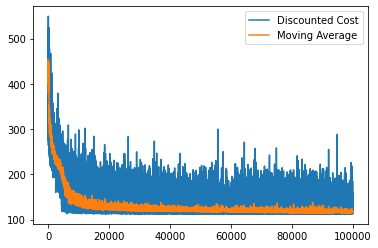

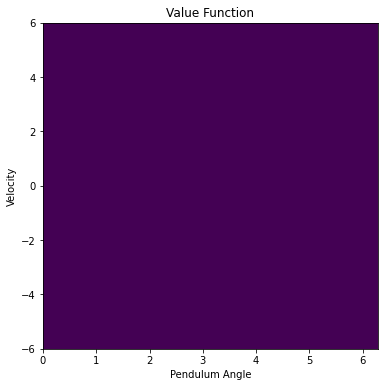

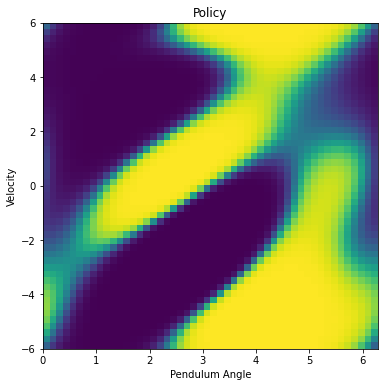

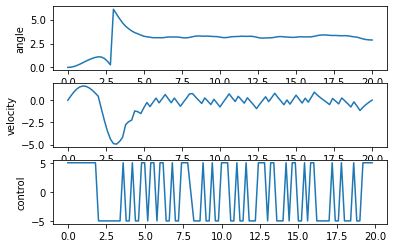

In [8]:
# here we create all the objects
pendulum = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum.controls, order = 2)
# to be used for the baseline
# value = ValueFunctionPeriodicFeatures(order = 2)
reinforce = Reinforce(pendulum, cost, policy, episode_length=100, 
                      discount_factor=0.99, policy_learning_rate = 5e-8)

## lr=5e-9 works in 10000 steps
## lr=7e-9 works in 10000 steps
## lr=1e-8 works in 10000 steps
## lr=5e-8 works in 10000 steps

# here we learn doing 300 episodes
lear = reinforce.iterate(100000) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear, label="Discounted Cost")
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg, label="Moving Average")
plt.legend(loc="upper right")

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum, val, pol, control_policy, animate=True)

### REINFORCE with Baseline

In [0]:
class ReinforceBaseline:
    """
    An implementation of the reinforce algorithm with baseline)
    """
    
    def __init__(self, model, cost, policy, value, discount_factor=0.99, 
                 episode_length=100, value_learning_rate=1e-3, policy_learning_rate = 0.000001):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost

        self.policy = policy
        self.value = value
        
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
        self.value_learning_rate = value_learning_rate
            
    def iterate(self, num_iter=1):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        
        for i in range(num_iter):  
            # generate an episode - start from 0
            x_traj[0,:] = np.zeros([2])
            # TO COMPLETE #
            # you can use the step function of self.model (i.e. the pendulum) to get the next state
            G = 0
            ## generate an episode
            for t in range(self.episode_length):
                x = x_traj[t,:]

                ## take one step and get cost
                idx, u = self.policy.sample(x)
                g = self.cost(x, u)

                ## update buffer
                x_traj[t+1] = self.model.step(x, u)
                u_traj[t] = u
                u_index[t] = idx
                cost_traj[t] = g

                G += g * self.discount_factor**t
            
            # now compute the returns Gt and update the policy parameters self.policy.theta through gradient descent
            # TO COMPLETE #
            for k in range(self.episode_length):
                x, idx = x_traj[k], u_index[k]
                dist, basis_fun = self.policy.get_distribution(x)

                alpha = np.array([self.discount_factor**i for i in range(self.episode_length-k)])
                Gt = alpha @ cost_traj[k:]
                V, v_basis = self.value.getValue(x)
                delta = Gt - V

                ## update value function
                dv = v_basis * delta
                self.value.theta += self.value_learning_rate * self.discount_factor**k * dv

                ## update policy
                dtheta = basis_fun[:, idx] - basis_fun @ dist
                self.policy.theta -= self.policy_learning_rate * self.discount_factor**k * delta * dtheta

            # here we store the return at t=0 to get the learning progress
            print(f"Iteration: {i}, Discounted Cost: {G}")
            learning_progress.append(G)
                
        return learning_progress
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                val[i,j] = self.value.getValue(np.array([x,v]))[0]
        return pol, val

Streaming output truncated to the last 5000 lines.
Iteration: 95001, Discounted Cost: 114.25467507889265
Iteration: 95002, Discounted Cost: 114.30244735757486
Iteration: 95003, Discounted Cost: 113.16939020195974
Iteration: 95004, Discounted Cost: 112.81067965754741
Iteration: 95005, Discounted Cost: 114.07392705137684
Iteration: 95006, Discounted Cost: 113.18456262891264
Iteration: 95007, Discounted Cost: 113.36677934575256
Iteration: 95008, Discounted Cost: 113.09523420169596
Iteration: 95009, Discounted Cost: 112.76900913119891
Iteration: 95010, Discounted Cost: 113.30298610907813
Iteration: 95011, Discounted Cost: 113.44975076952093
Iteration: 95012, Discounted Cost: 114.5964976162919
Iteration: 95013, Discounted Cost: 113.40344764382013
Iteration: 95014, Discounted Cost: 113.28363432375066
Iteration: 95015, Discounted Cost: 115.05059842836833
Iteration: 95016, Discounted Cost: 112.75174249956133
Iteration: 95017, Discounted Cost: 113.5193679930807
Iteration: 95018, Discounted Cost

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABe2G1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAo8ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMADN2InuDwrXQ9FeAAICAAUTkeZCngr+AB
s+FTpEmHxPfww3BGSVzNCQT4FB6nH/jCVfIK24/+f/sObypPxVLtoT/SYXSQfLGPhj7If3KZYQ8A
uNzY9zndDTeyrDqZPtoKhc+YaS6qwXCiW60pfdrBsVWRuY8P7jk3LkUXLCkthkSGY3ZJdtpwwUY8
a4TblPEsHiltHY5/OI1Ai/ijkMBXprACBRzHpDNyHDfK7ua7sdQGjlbj2kN6fLlfTOf8dF5ii1YQ
kytmo69aubYLVinmLhrMJ5zBf+uY7HfL9WlhMPpFWOZXZuteeq6MMcv5z2Vm41Bk9TP/idxcoawo
U/fvNoavikL1aRSh9nrltGVtexddt1PuSisJBP1G0m0np2ipUG1G97ZKc5dLxX/wZOC763a929GM
nhjMeb5oGfouuG8bAXq6bupxVy9nbA8km+FXaYBt1W53YAcor19URFeYYshvb8j93cRcVe1zS/bP
qgkX92zhC0k3Lw9NV7F/gdKcUP53CRdg3uCB3gX8yg4Rq3paaBbklWjQQaj9OrmfcpSlrkFhtepc
mwGUTZx0H95U2WTbsipng6SoHK7X1yM3+SF4MTn5QxMjTQzLv5q3m85KwVrvgyDoyAQvOKeTC/XW
RGsPW/veLuP4LP5Z0o2/hPsSbdzLdHQPaTw5UOfyUF2byaYY1TkqU2oomcc+SBiC9OMctYiy7644
VDDlSDgxgduL5EGnTrj9Rc6gy56xD/h50gtx8qi8FQpgxzBZcM+BaHje6goFLtCREK5bexBQw8yl
oOcJsBzWaG0/ZVjM+rgE1gAjog7jcuUh81Q3GxoJFl55O32lORoSf8/+XwbHMkUf9oO692ZPx03+
/mtk948KKMLgKg2z5YCPDDO/f/VHr0lgAJiAqa/KRJgAlqKooRqdyyk4f4kC/Jx4AMPqzBtU6fmw
mpNEy/O8jIxUqy8XZ7sZ4cd6S5auDEQ8CrDQKYvLFy3txHWrrmQEmv85UfrwtN7RjRhvzA6txNmc
P80Xl+FN7Ggc+36Cd2DDEfcMhY+naiTGffCXFNvBiEmcPjwz4ZctS4TAjywVjTZ2Zng4JdFXJy6s
wNzuQrpRXDWvK7y1eNvm6bVLuv4tq5Lvw0U+INJ9age2DM00oFwlu/OOfEsCVHCzp9SsP9JrDZNx
8FimbxQiEoz4SxEwuoAVoQTaL/hXkOfi8ImzlAX1rhBTZNsaAY7fkmKP2D3FpXwNV1MUDjHo1/VT
8yL8737YqANxLbeIJ2wigJs3RHxYIjgl3/PVSe4PcejciMZrumgywxvMlvBaCnTYwNuQTHqc1JY2
lp+WBmUMWGPo7EN1yPU8x8O2AeVkst0epZkp3Lc7yBI7phtF1KqhADALkkAbrjqxRS70gbqAuIlp
xL6YgrQ3UWM/16wH+KRwtYnezQ0qCP/juFzShFlfP3tSmDovK+l3/4fjLHQL9hGwtMWlfYc7Qg8V
E47svxzwYeJBTUlKxc/WDsTyZL9r/39okrZGYzfuekz5fPOGodEBrMBLI7yu09qaf9cEuHsIWeKq
/Kf6It5oP/CDTqsP8Gr7vABWrNUv6ToT28irj/gIAR3YT6G2RYil/Qf71EBU25aAUo2PbwE+WH5y
ENmjvtopt7SW39t7M6H2rqeDCQvAmLyUnLdgX4THoUo3wuOKkLUAKS4pNNmRrX8hNs9BXc/P8Qf0
m8zt9aAR//mUQ+2yrIG4djz5dBylQ30rL0xT7aaqh/0T765mhH1ag1pjlvjFgUHR/UhGfMhP7+w7
d7scr40uN06KGA/ygSEmuAACQAAAAwAhT39g30OilpEBg8JAH/lNRIPJtOn9lGM3vYA1WFRyZHFn
YJ0e7TMC2L/+bCQ++fp+YVqsYx78vFh9KvYV+V/b3LqCUlTGvdA/tThMw/sLc32S+o8daBOs2j2l
Nd0FZfYUllHXmLbtIB+PTsdHob4JcK4uLXNa3CvnNZYEoAXt5L1dbhwviYWXTNHCCRK1nS8rQbv+
irrv0wtlVhayM45v/3WXO9ooXEnPgLSHX5Axp/qV7Rsep2WMf8rMVfQTs1kosB5WvmwFzCTvdmZ+
STbk6c80+WxslaJ2FcFjvEi7ePbKPv2f3pOb37Z7PAWR8jS4uT7YsrbclhvAiopBO36Cq3bfmxaJ
WbnQpdHmpGW5lUoMddmxwc2HtX+KxyzjmBtxb4hNxxiWFV4h9J/gGG2NEPNPHJPhjDdbPGAi/Kgj
pKACqc+TEaw8oblSKNZxMUOOmt3A6MtDlYKk+a2mqpP31hRjzBtGsAknT8JHtDngMagEliOdBYdu
FNj4wagcRMDak8rhTZsGgwsWIbUZpfmw71HML9zNpUeDmSRz6M6cWb8Obbtj79kugbCgqnACdo/7
XA6a9CMkPB/WVO7qnE4cbFN5Jm8cBxtm/h5Dic+Iwx7yyLXQm41VTKY91UnbKWksbKJrFqktPKIE
DomYVri8tvMj0M9YXVGmIk0samnjYOZ1diSzsX1UL6o7fFOy85i2BbmlZldKWKF90CuDtEVdOpH0
4VXivgfsY/HH90BucD+C/wdNQc+v2aSPBRg+nTEAeCY1S5Gwza/G+eFBVclSZsZFyszfKyqzWJkP
653hjiP91bgqtsssGHAmJi85UxFl4IohQs3gipBoTFa8WOD88N4xozXaFUaUD6G69zUGOgAYrm0k
Xtnp662+/vcjI7Y597zZu6ia4VxjdFlC9d6d/8riudFcRiteKLHJuwGgBiB7h0NMUQhrHegBwYxJ
LpWqYLlUIunpeAQCFZHkcPHcdMSJJ/lCcROACd9AWFjqJ5auBLBCgmjjfAnk8FXqadQr9V5NJX3i
PjFnGtyW32vR9DpT3LExV

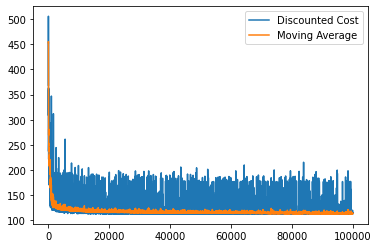

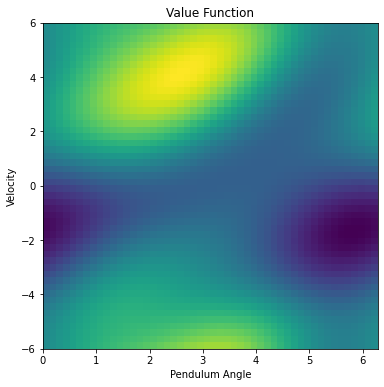

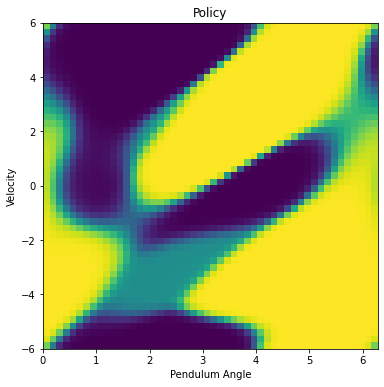

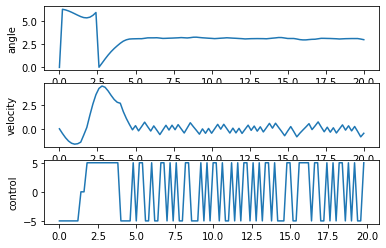

In [10]:
# here we create all the objects
pendulum = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum.controls, order = 2)
# to be used for the baseline
value = ValueFunctionPeriodicFeatures(order = 2)
reinforce = ReinforceBaseline(pendulum, cost, policy, value, episode_length=100, 
                              discount_factor=0.99, value_learning_rate=1e-2, policy_learning_rate = 1e-6)

## vlr = 1e-2, plr=1e-7 works in 10000 steps
## vlr = 1e-2, plr=5e-7 works in 10000 steps
## vlr = 1e-2, plr=1e-6 works in 10000 steps


# here we learn doing 300 episodes
lear = reinforce.iterate(100000) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear, label="Discounted Cost")
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg, label="Moving Average")
plt.legend(loc="upper right")

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum, val, pol, control_policy, animate=True)